# Twitter Sentiment Analysis Dataset - Overview
# This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [1]:
!pip uninstall -y tensorflow-serving-api
!pip install numpy==1.19.2
!pip install awswrangler
!pip install wordcloud
!pip install pyathena
!pip install tensorflow-cpu==2.6.1
!pip uninstall -y keras

  Using cached numpy-1.19.2-cp36-cp36m-manylinux2010_x86_64.whl (14.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.6.1 requires keras~=2.6, which is not installed.
awswrangler 2.14.0 requires numpy<1.19.0,>=1.18.0; python_full_version ~= "3.6.2", but you have numpy 1.19.2 which is incompatible.
  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tenso

# Create folders to save our model result files

In [2]:
import os
current_path = os.getcwd()
os.makedirs(f'{current_path}/random_forest_model_files', exist_ok = True)
os.makedirs(f'{current_path}/keras_model_files', exist_ok = True)

# Load references to the folder cloned from GitHub repo

In [3]:
import sys
sys.path.append('/home/ec2-user/SageMaker/ConcurMLWorkshop/03_Model_Building/')

# Import Headers

In [4]:
# Pandas, SKLEARN headers
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
tqdm.pandas()
pd.set_option('max_colwidth',0)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pretty_confusion_matrix import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import joblib
import pickle
import io
import os
import json

#NLTK headers
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import awswrangler as wr

# Keras headers
import tensorflow as tf
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
#from pandas_profiling import ProfileReport

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Declare variables based on what you have already provided in the previous sessions
S3_BUCKET_FOLDER = 's3://twitter-sentiment-adithya-kumar/model-training/model-results/'
ATHENA_STAGING_FOLDER = 's3://twitter-sentiment-adithya-kumar/athena_log/'

# If you have attended the previous session and have loaded the data in the athena table

In [6]:
from pyathena import connect
import pandas as pd

conn = connect(s3_staging_dir=ATHENA_STAGING_FOLDER,
               region_name="us-west-2")
df = pd.read_sql_query(""" SELECT * FROM "enrich_db"."enriched_data" """, conn)

# If otherwise, please ignore the command above and run the below command after removing the hash in front

In [7]:
df = pd.read_csv('input-dataset.psv', sep='|')

In [8]:
df.head(2)

,id,dp_unique_key,target,text,updated_date,entity
0,12924,uq_id_10016,Neutral,"It's hard for some, it's even harder for others, but this morning was fun, this crap made me laugh so much, I remember the first wave and the second wave are no different.",21-03-2022,Xbox(Xseries)
1,12931,uq_id_10058,Irrelevant,Always ghblbe in it to win it great giveaway!,21-03-2022,Xbox(Xseries)


# Rename columns

In [9]:
# Rename columns
df.columns = ['tweet_id', 'dp_unique_key', 'sentiment', 'tweet_text', 'updated_date', 'entity']

# Look at dataset

In [10]:
df.tail(5)

,tweet_id,dp_unique_key,sentiment,tweet_text,updated_date,entity
77363,2573,uq_id_976,Negative,This cricket has been dubbed the worst single hivemind of game fandom I have certainly done this more times more than I or would love to be better if the Tarzan level in Kingdom Hearts is as bad there as Borderlands.,21-03-2022,Borderlands
77364,12897,uq_id_9854,Positive,Welp. Ruthless Sony can best explain why I made my choice.,21-03-2022,Xbox(Xseries)
77365,12909,uq_id_9929,Positive,The news there keeps getting better and better. VERY really looking forward to picking up my Series III from day one (and playing Dark Infinite with @runslikedeb immediately),21-03-2022,Xbox(Xseries)
77366,12914,uq_id_9956,Positive,Very interesting.......,21-03-2022,Xbox(Xseries)
77367,12916,uq_id_9971,Positive,A great console for a noble cause,21-03-2022,Xbox(Xseries)


In [11]:
df.sentiment.value_counts()

Negative      23185
Positive      21739
Neutral       19357
Irrelevant    13087
Name: sentiment, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77368 entries, 0 to 77367
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       77368 non-null  int64 
 1   dp_unique_key  77368 non-null  object
 2   sentiment      77368 non-null  object
 3   tweet_text     77368 non-null  object
 4   updated_date   77368 non-null  object
 5   entity         77368 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.5+ MB


# According to the dataset, they regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [13]:
df['sentiment'] = np.where(df.sentiment=='Irrelevant', 'Neutral', df.sentiment)

# Filter out rows where tweet_text is NULL

In [14]:
# fiter data where tweet is present
df = df[df.tweet_text.isnull()==False]
df['tweet_text'] = df['tweet_text'].astype(str)

# Stratified Sampling - For this session purposes lets restrict to 8000 records for each class

In [15]:
number_of_rows_each_class = 8000
dfs_list = []
for unique_sentiment in np.unique(df.sentiment):
    df_sentiment = df[df.sentiment == unique_sentiment]
    if df_sentiment.shape[0] > number_of_rows_each_class:
        df_sentiment = df_sentiment.sample(n=number_of_rows_each_class, random_state = 42)
        
    dfs_list.append(df_sentiment)
df = pd.concat(dfs_list)
df = df.sample(frac=1, random_state = 42)
df = df.reset_index(drop = True)

In [16]:
df.sentiment.value_counts()

Neutral     8000
Negative    8000
Positive    8000
Name: sentiment, dtype: int64

# We might want to look at what is present in the tweets. So a wordcloud can be helpful

In [17]:
import os
from wordcloud import WordCloud
def word_cloud(tweets):
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array    
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                           background_color="black", max_words=2000, 
                           contour_width=1, contour_color="steelblue", 
                           colormap="nipy_spectral").generate(tweets)

    #Now we plot the figure
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()   


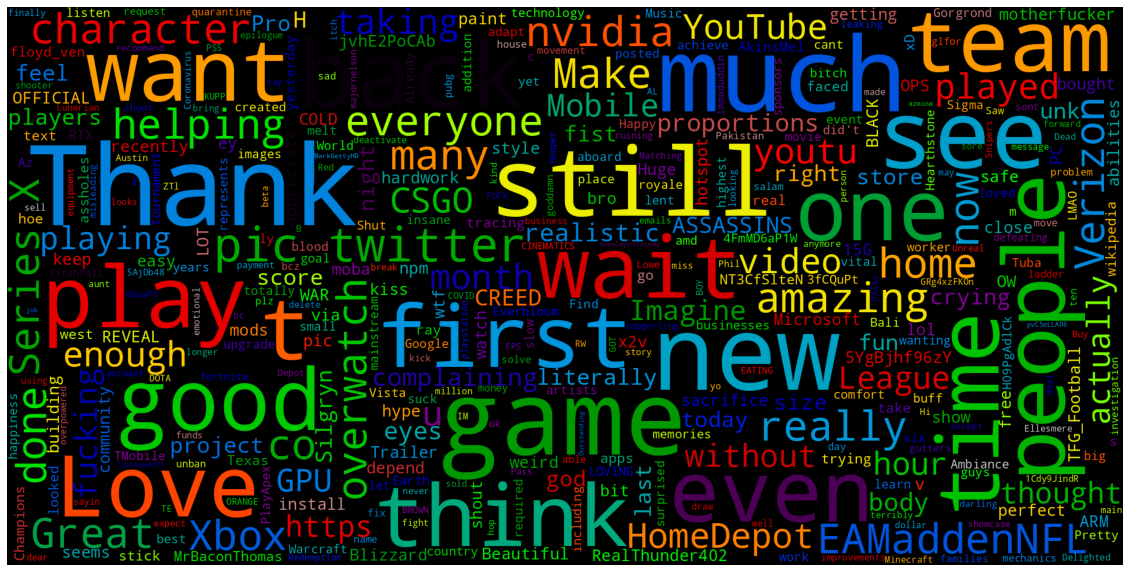

In [18]:
# Positive tweets word cloud
sample_df = df[df.sentiment=='Positive'].tweet_text.head(50)
word_cloud(sample_df.str.cat(sep=' ')) 

# Define output labels as integers

In [19]:
# Assign each of the classes to a number as certain ML models doesn't accept strings 
class_to_index = {"Neutral":0, "Negative":1, "Positive": 2}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

#Convert the "Sentiment" column into indexes
df["sentiment_index"] = names_to_ids(df["sentiment"])

# Modelling - Classic TF-IDF model


# Prepare dataset for modelling

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet_text):
    # removes punctuations, numbers from text
    tweet_text = re.sub('[^a-zA-Z]', ' ', tweet_text)
    # Convert to lower case
    tweet_text = tweet_text.lower()
    # Split the text by space
    tweet_text = tweet_text.split()
    tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if (not(word in set(stopwords))) & (len(word)>1) ]
    tweet_text = ' '.join(tweet_text)
    return tweet_text

df['tweet_text_preprocessed'] = df['tweet_text'].progress_apply(preprocess_tweet)
df = df[df.tweet_text_preprocessed.apply(lambda text: len(text.split())>1)]
#df['tweet_tokenized'] = df['tweet_tokenized'].progress_apply(lemmatize)



100%|██████████| 24000/24000 [00:04<00:00, 4849.92it/s]


In [21]:
# Example of pre-processing
a = 'hi 9 9ad .aaa super    awesome'
preprocess_tweet(a)

'hi ad aaa super awesome'

# Take a look at pre-processed text

In [22]:
df[['tweet_text','tweet_text_preprocessed', 'sentiment']].head(30)

,tweet_text,tweet_text_preprocessed,sentiment
0,"Amazon Prime Day is still running, but belatedly.",amazon prime day still running belatedly,Negative
3,I Love Microsoft paint lol close enough ey pic.twitter.com/jvhE2PoCAb,love microsoft paint lol close enough ey pic twitter com jvhe pocab,Positive
5,she is getting absolutely comfortable with these nerfs :(,getting absolutely comfortable nerfs,Negative
6,C. HP Lovecraft + Punk = Scary. caf.tv / divideacon,hp lovecraft punk scary caf tv divideacon,Negative
7,That's why I didn't buy Borderlands 3. Randy Pitchford is damn scum.,buy borderland randy pitchford damn scum,Negative
8,I got the best horses in the back,got best horse back,Neutral
9,Thank you Blizzard..,thank blizzard,Positive
10,"""\""@GhostRecon What's wrong with the game NOW? Why can't we \""\""connect\""\""?. . And, will you ever fix this game. The silence is deafening.\""""",ghostrecon wrong game connect ever fix game silence deafening,Negative
11,"BLACK OPS COLD WAR OFFICIAL REVEAL! (New Trailer Thoughts) youtu.be/5YgBjhf96zY via @YouTube I can’t wait bro! Love the video, getting me hype . @RealThunder402",black ops cold war official reveal new trailer thought youtu ygbjhf zy via youtube wait bro love video getting hype realthunder,Positive
12,Huge shout out to @TFG_Football for taking the time to show people how easy it does npm install mods under the PC for @EAMaddenNFL . - youtube.com/watch?v=29-x2v…,huge shout tfg football taking time show people easy npm install mod pc eamaddennfl youtube com watch,Positive


# Take a look at the number of rows

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22281 entries, 0 to 23999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 22281 non-null  int64 
 1   dp_unique_key            22281 non-null  object
 2   sentiment                22281 non-null  object
 3   tweet_text               22281 non-null  object
 4   updated_date             22281 non-null  object
 5   entity                   22281 non-null  object
 6   sentiment_index          22281 non-null  int64 
 7   tweet_text_preprocessed  22281 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.5+ MB


# Split into train and test

In [24]:
train_df, test_df = train_test_split(df,test_size = 0.05, random_state =42)

train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

X_train = train_df['tweet_text_preprocessed']
y_train = train_df['sentiment']

X_test = test_df['tweet_text_preprocessed']
y_test = test_df['sentiment']

# Use TF IDF Vectorizer 

In [25]:
# TF-IDF feature matrix
max_number_of_words = 5000
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95, min_df=2, max_features=max_number_of_words, lowercase =True, stop_words='english', token_pattern=r'\w{3,}')
tfidf_vectorizer.fit(X_train)
print('No. of feature_words: ', len(tfidf_vectorizer.get_feature_names()))
X_train = tfidf_vectorizer.transform(X_train)
X_test  = tfidf_vectorizer.transform(X_test)

No. of feature_words:  5000


# Check out IDF for each record to get an idea about key words in that line

In [26]:
index = 0
print()
tfidf_df = pd.DataFrame(X_train[index].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["TF-IDF"])
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
print (train_df['tweet_text_preprocessed'].iloc[index])
print (tfidf_df.head(5))
print()

index = 1
tfidf_df = pd.DataFrame(X_train[index].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["TF-IDF"])
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
print (train_df['tweet_text_preprocessed'].iloc[index])
print (tfidf_df.head(5))


ghost recon breakpoint become excellent stake distraction game way anyone couldnt help game wont past title screen latest update please help ubisoftsupport ghostrecon ghostrecon uk
              TF-IDF
help        0.372800
ghostrecon  0.371079
wont        0.289839
excellent   0.262028
title       0.256329

united onslaught get divine evolvable rank app store bit ly azhykp google play bit ly ntcnts
          TF-IDF
bit     0.608663
united  0.422062
rank    0.388311
app     0.325807
store   0.291248


# Fit Random Forest model

In [27]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Export Random Forest model and tokenizer

In [28]:
# export model
joblib.dump(tfidf_vectorizer, f'{current_path}/random_forest_model_files/tfidf_vectorizer.joblib')
joblib.dump(rf_clf, f'{current_path}/random_forest_model_files/random_forest.joblib')

['/home/ec2-user/SageMaker/twitter-sentiment-analysis/random_forest_model_files/random_forest.joblib']

# Predict Random Forest model on test dataset

In [29]:
rf_predictions = rf_clf.predict(X_test)

# View model results

/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible i

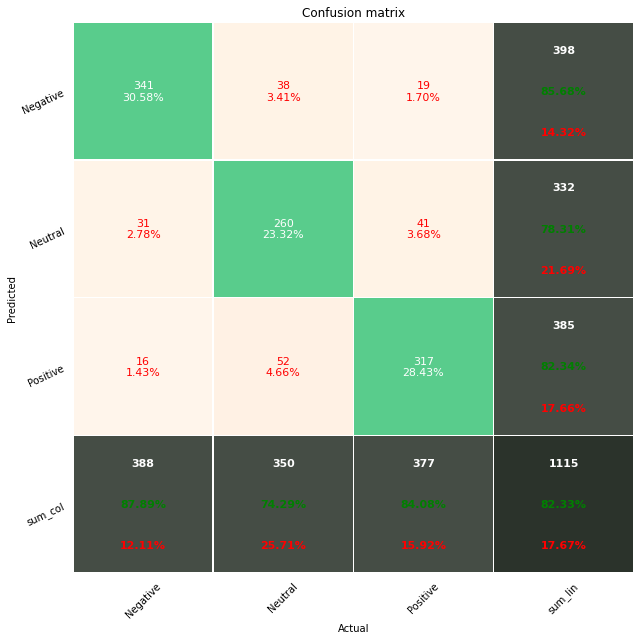

In [30]:
from pretty_confusion_matrix import *
pp_matrix_from_data(y_test, rf_predictions, columns = ['Negative', 'Neutral', 'Positive'])

# TRY IT OUT - Predict on a test data point

In [31]:
# predict
# load
tfidf_vectorizer = joblib.load(f'{current_path}/random_forest_model_files/tfidf_vectorizer.joblib')
rf_clf = joblib.load(f'{current_path}/random_forest_model_files/random_forest.joblib')
negative_tweet_text = 'That is really a bad service'
positive_tweet_text = 'i had an excellent service'
def predict(tweet_texts, tfidf_vectorizer):
    processed_texts = []
    for tweet_text in tweet_texts:        
        tweet_text = tweet_text.split()
        tweet_text = [lemmatizer.lemmatize(word) for word in tweet_text if not word in set(stopwords)]
        tweet_text = ' '.join(tweet_text)
        processed_texts.append(tweet_text)
    tweet_texts_tfidf = tfidf_vectorizer.transform(processed_texts)
    predictions = rf_clf.predict(tweet_texts_tfidf)
    return predictions
predict([negative_tweet_text, positive_tweet_text], tfidf_vectorizer)

array(['Negative', 'Positive'], dtype=object)

# Keras tokenization word embedding model

# Keras model - Load tokenizer and save tokenizer

In [32]:
max_words = 5000
max_len=50

keras_tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')


def tokenize_pad_sequences(tweet_text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    tweet_text = tokenizer.texts_to_sequences(tweet_text)
    # Pad sequences to the same length
    tweet_text = pad_sequences(tweet_text, padding='post', maxlen=max_len)
    # return sequences
    return tweet_text

keras_tokenizer.fit_on_texts(train_df['tweet_text_preprocessed'])
train_texts_to_sequences = keras_tokenizer.texts_to_sequences(train_df['tweet_text_preprocessed'])
train_texts_to_sequences = pad_sequences(train_texts_to_sequences, padding='post', maxlen=max_len)

train_df['tweet_keras_tokenized'] = list(train_texts_to_sequences)


test_texts_to_sequences = keras_tokenizer.texts_to_sequences(test_df['tweet_text_preprocessed'])
test_texts_to_sequences = pad_sequences(test_texts_to_sequences, padding='post', maxlen=max_len)

test_df['tweet_keras_tokenized'] = list(test_texts_to_sequences)


# saving
# with open('keras_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(keras_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

tokenizer_json =  keras_tokenizer.to_json()
with io.open(f'{current_path}/keras_model_files/keras_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Define Keras model

In [33]:
keras_model = Sequential()
embedding_vector_size = 36
lstm_units = 50
keras_model.add(Embedding(max_words,embedding_vector_size,input_length=max_len))
keras_model.add(Bidirectional(LSTM(20, return_sequences=True)))
keras_model.add(Bidirectional(LSTM(lstm_units)))
keras_model.add(Dense(4, activation='softmax'))
keras_model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy'])

# Train Keras Model

In [34]:
X_train_keras = train_texts_to_sequences
y_train_keras = train_df['sentiment_index']

X_test_keras = test_texts_to_sequences
y_test_keras = test_df['sentiment_index']

keras_model.fit(
     X_train_keras, y_train_keras,
     validation_data=(X_test_keras, y_test_keras),
     epochs=3)

Epoch 1/3
662/662 [==============================] - 44s 57ms/step - loss: 0.8547 - accuracy: 0.5990 - val_loss: 0.6824 - val_accuracy: 0.7112
Epoch 2/3
662/662 [==============================] - 36s 54ms/step - loss: 0.5716 - accuracy: 0.7712 - val_loss: 0.6248 - val_accuracy: 0.7489
Epoch 3/3
662/662 [==============================] - 37s 56ms/step - loss: 0.4463 - accuracy: 0.8276 - val_loss: 0.6013 - val_accuracy: 0.7623


# Test model on test data set

/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/ec2-user/SageMaker/twitter-sentiment-analysis/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible i

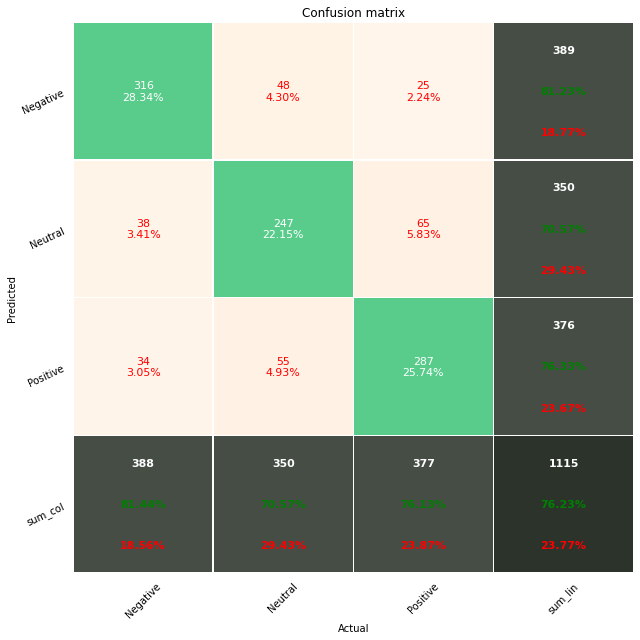

In [35]:
#Generate predictions
keras_predictions = np.argmax(keras_model.predict(test_texts_to_sequences), axis=1)

#Assign labels to predictions and test data
keras_prediction_labels = ids_to_names(keras_predictions)
#y_test_labels = ids_to_names(y_test)

from pretty_confusion_matrix import *
pp_matrix_from_data(test_df['sentiment'], keras_prediction_labels, columns = ['Negative', 'Neutral', 'Positive'])

# Save model

In [36]:
save_model(keras_model, f'{current_path}/keras_model_files/', save_format='tf')

INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/twitter-sentiment-analysis/keras_model_files/assets


INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/twitter-sentiment-analysis/keras_model_files/assets


In [37]:
test_df.head(2)

,tweet_id,dp_unique_key,sentiment,tweet_text,updated_date,entity,sentiment_index,tweet_text_preprocessed,tweet_keras_tokenized
0,7169,uq_id_67553,Neutral,"Everyone thought that the GDP for China would fake or at best very inadequate, this virus will show that its GDP is atrocious. not only the high toll that will take away from the workforce of specific areas but her workers will pull more. @RomanWenzl More @sh_irredeemable",21-03-2022,johnson&johnson,0,everyone thought gdp china would fake best inadequate virus show gdp atrocious high toll take away workforce specific area worker pull romanwenzl sh irredeemable,"[117, 283, 866, 56, 879, 21, 1249, 199, 374, 131, 361, 3850, 980, 511, 1247, 2749, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,12673,uq_id_20282,Positive,"Oooh, just completed the guild of dragons this season and got Bruce, the most horrible battleship Crocs!",21-03-2022,WorldOfCraft,2,oooh completed guild dragon season got bruce horrible battleship crocs,"[1832, 2122, 1197, 257, 27, 1039, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Combine datasets results and save it to S3

In [38]:
test_df['rf_output_labels'] = rf_predictions
test_df['keras_output_labels'] = keras_prediction_labels
test_df = test_df.reset_index(drop = True)
wr.s3.to_parquet(
    df=test_df[['tweet_id', 'tweet_text', 'sentiment', 'rf_output_labels', 'keras_output_labels']],
    path=S3_BUCKET_FOLDER,
    dataset=True
)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


{'paths': ['s3://twitter-sentiment-adithya-kumar/model-training/model-results/1e3f6628de704b4a8b3aea260a5f9377.snappy.parquet'],
 'partitions_values': {}}

# Predict for a test data point

In [39]:
# Predict in Keras
with open(f'{current_path}/keras_model_files/keras_tokenizer.json') as f:
    data = json.load(f)
    keras_tokenizer = tokenizer_from_json(data)

reconstructed_keras_model = load_model(f'{current_path}/keras_model_files/')

preprocessed_tweet = [preprocess_tweet(tweet_text) for tweet_text in [negative_tweet_text, positive_tweet_text]]

predict_texts_to_sequences = keras_tokenizer.texts_to_sequences(preprocessed_tweet)
predict_texts_to_sequences = pad_sequences(predict_texts_to_sequences, padding='post', maxlen=max_len)

keras_predictions = np.argmax(reconstructed_keras_model.predict(predict_texts_to_sequences), axis=1)

keras_prediction_labels_test = ids_to_names(keras_predictions)

keras_prediction_labels_test

array(['Negative', 'Positive'], dtype='<U8')

# TRY IT OUT : Train model on full dataset and see if you see the model accuracy improving

# TRY IT OUT : Add callbacks to Keras model to stop model training if validation loss stops improving